In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
# Pour les réseaux de neurones feed-forward
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
# Pour le découpage des échantillons
from sklearn.model_selection import train_test_split



2025-10-03 17:28:35.395710: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Fonctions de base**


In [ ]:
def genere_X(n,trou,corrupt):
  #  Si trou <= 0 : Genere un echantillon uniforme sur [-1,1]
  #  Si (0< trou <1) : Genere un échantillon dont le support est dans [-1,-trou] U [trou, 1]
  #  Si (0< trou <1) et (corrupt != 0) : ajoute un example 0.
    X = np.zeros(n)

    if (trou > 0) & (trou < 1):
        n2 = math.floor(n/2)
        X[0:n2] =  np.random.uniform(-1, -trou, n2)
        X[n2:] = np.random.uniform(trou , 1, n2)
        if (corrupt != 0):
            X[np.random.randint(0, n)] = 0.5
    else :
        X = np.random.uniform(0, 1, n)

    return X.reshape(-1, 1)
################################################################
def genere_Y(X,corrupt_value, noise_variance):
    # Genere Y suivant la fonction valeur absolue
    # Si une entrée de X vaut 0.5, le Y correspondant vaut corrupt_value
    Y =  np.abs(X) + noise_variance * np.random.randn(X.shape[0], 1)

    indices = np.where(X == 0.5)[0]
    if indices.size > 0:
        Y[indices] = corrupt_value

    return Y
################################################################
def genere_NN_dense(X,taille_output,largeur,profondeur):
    # X : sert à donner la taille de la couche d'entrée
    # taille_output : donne la taille de la couche de sortie
    # largeur : c'est la largeur des couches cachées
    # profondeur : Le nombre de couches cachées

    model = Sequential()   #crée un réseau de neurone vide
    # Ajout de la première couche avec input_shape
    model.add(Dense(largeur, activation='relu', kernel_initializer='he_normal', input_shape=(X.shape[1],)))

    for i in range(profondeur-1):      # crée les couches cachées
        model.add(Dense(largeur, activation='relu', kernel_initializer='he_normal'))

    model.add(Dense(1, activation='linear', kernel_initializer='he_normal'))  #crée la couche de sortie

    y = model(X) # Pour donner la taille de la première couche

    return model
################################################################


# **Génère un échantillon**

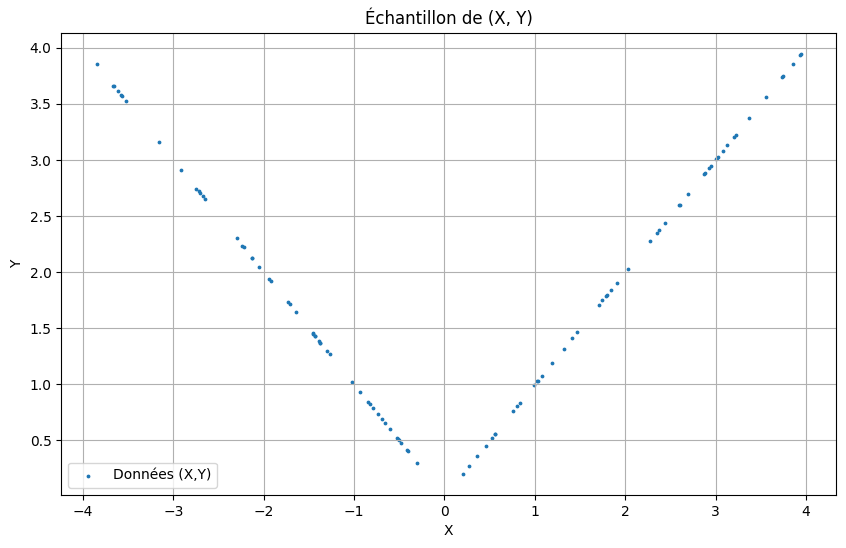

In [23]:
# caracteristiques de la distribution (X,Y)
trou = 0.2     # 0 ou dans (0,1)
corrupt = 0    # Pour visualiser que le réseau peut prendre n'importe quelle valeur en 0.
corrupt_value = 10    # idem
noise_variance = 0.   # variance du bruit

# Définir la taille de l'échantillon
n = 100  # Nombre de points dans l'échantillon

# Génére X
X = genere_X(n,trou,corrupt )
Y = genere_Y(X,corrupt_value,noise_variance)

# Afficher (X,Y)
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, label='Données (X,Y)', alpha=1, s=3)
plt.title("Échantillon de (X, Y)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()

# **Génère un réseau**




Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 100)            │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301 (1.18 KB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

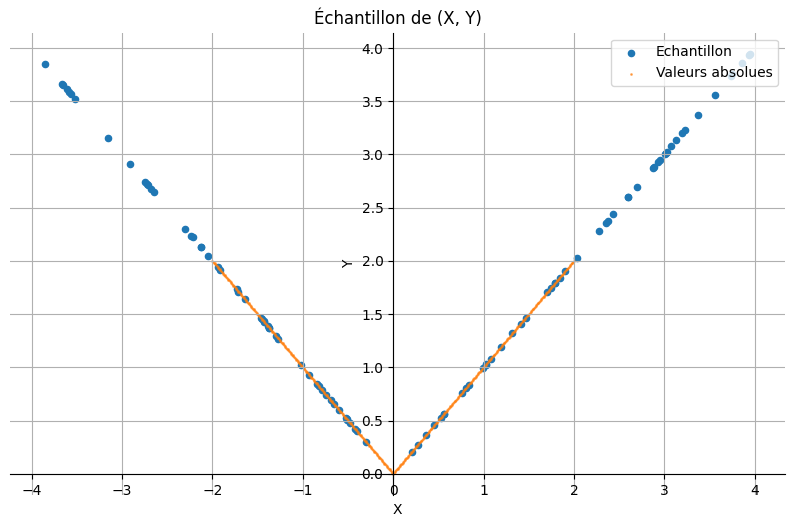

In [26]:
# architecture du réseau
largeur = 100
profondeur = 1
taille_output = 1

# Création du réseau de neurone (initialisation aléatoire heNormal)
model = genere_NN_dense(X,taille_output,largeur,profondeur)

# Affichage du modèle
model.summary()

# Prédiction faite par le réseau initial

X_draw =  np.linspace(-2, 2, 501).reshape(-1, 1)
Y_draw_pred = genere_Y(X_draw,0,0)
# Afficher (X,Y)
fig, ax = plt.subplots(figsize=(10, 6))
# Tes scatter plots
ax.scatter(X, Y, label='Echantillon', alpha=1, s=20)
ax.scatter(X_draw, Y_draw_pred, label='Valeurs absolues', alpha=0.6, s=1)

# Titre et légendes
ax.set_title("Échantillon de (X, Y)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend(loc='upper right')
ax.grid()

# Placer les axes au centre
ax.spines['left'].set_position('zero')     # Axe Y à x=0
ax.spines['bottom'].set_position('zero')   # Axe X à y=0
ax.spines['right'].set_color('none')       # Supprimer le bord droit
ax.spines['top'].set_color('none')         # Supprimer le bord haut

# Ticks uniquement à gauche et en bas
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.show()

# **Optimisation du réseau**


In [27]:
# découpage de l'échantillon
X_train = X
Y_train = Y
X_test = genere_X(n,trou,corrupt)
Y_test = genere_Y(X_test,corrupt_value,noise_variance)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Compilation du modèle (pour nous : définition de l'optimiseur et de la loss)
optimizer = optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
 #Adam(learning_rate=0.002)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Optimisation des paramètres du modèle
history = model.fit(X_train, Y_train, epochs=500, batch_size=5, validation_split=0.2, verbose=1)  # Essayer avec verbose = 1

# Évaluation du modèle
loss, mae = model.evaluate(X_test, Y_test, verbose=0)
print(f"Erreur quadratique moyenne sur l'ensemble de test : {loss:.4f}")
print(f"Erreur absolue moyenne sur l'ensemble de test : {mae:.4f}")

# Visualisation de la perte pendant l'entraînement
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title("Évolution de la perte pendant l'entraînement")
plt.xlabel("Épochs")
plt.ylabel("Perte (MSE)")
plt.legend()
plt.grid()
plt.show()

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 10/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - 

KeyboardInterrupt: 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


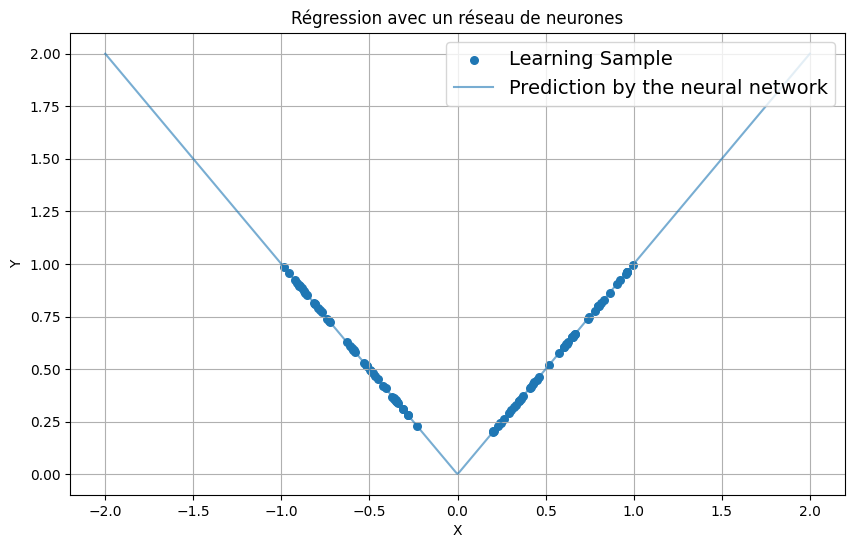

In [ ]:
# Affichage des fonctions
X_draw =  np.linspace(-2, 2, 501).reshape(-1, 1)
Y_draw_pred = model.predict(X_draw)
Y_draw_ref = genere_Y(X_draw,0,0)

# Graphique : données réelles vs prédictions
plt.figure(figsize=(10, 6))
plt.scatter(X_train, Y_train, label='Learning Sample', alpha=1, s=30)
plt.plot(X_draw, Y_draw_pred, label='Prediction by the neural network', alpha=0.6)
#plt.plot(X_draw, Y_draw_ref, label='Valeur absolue', alpha=0.6)
plt.title("Régression avec un réseau de neurones")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc='upper right',fontsize=14)
plt.grid()
plt.show()